## Simple Image Foreground Segmentation of Jelly Belly&copy; Beans

This is part of the work for FindJellybeans project.

In this project, we need to generate some synthesized and annotated images to help us quickly build up a training dataset. So here's a simple idea: patch some jelly bean images together and generate patch location at the mean time.

You can find out most jelly beans images from Jelly Belly&copy;'s website: https://www.jellybelly.com/flavor-guides

In [1]:
%matplotlib inline

# Library import
import random
import os
import os.path
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

So firstable, let's load in all bean images:

In [2]:
# Put your directory that stores all the jelly bean images here.
_BEANS_PATH = "" # Your bean image directory
_BEANS_OUTPATH = "" # Your segmented image directory

In [3]:
# Load in all images (exclude hidden file)
filenames = [f for f in os.listdir(_BEANS_PATH) if not f.startswith(".")]
beanflavours = [os.path.splitext(f)[0] for f in filenames]
filelist = [os.path.join(_BEANS_PATH, f) for f in filenames]
bean_imgs = [cv.imread(f) for f in filelist]

Then take a look at the first image occurs in the file list.

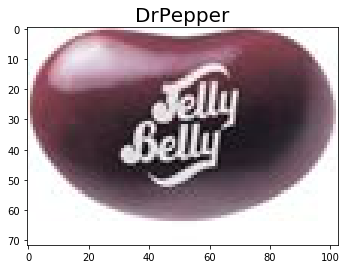

In [4]:
first_bean = bean_imgs[0]
plt.imshow(cv.cvtColor(first_bean, cv.COLOR_BGR2RGB))
plt.title(beanflavours[0], {"fontsize": 20})
plt.show()

To remove background, we can run segmentation function on our images. We're using GrabCut with default settings here, and only use the bounding box of the bean image as clue for the algorithm.

A nice example for GrabCut segmentation can be found in OpenCV's documentation:
https://docs.opencv.org/3.4.3/d8/d83/tutorial_py_grabcut.html

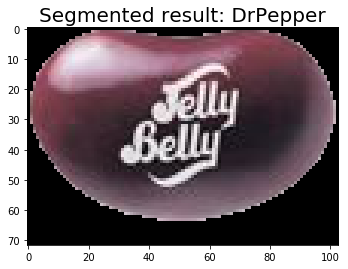

In [5]:
mask = np.zeros(first_bean.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# We can add some boundary, such as 1 pixel, to increase accuracy.
rect = (1,1, first_bean.shape[1] - 2, first_bean.shape[0] - 2)
cv.grabCut(first_bean, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
new_firstbean = first_bean * mask2[:,:,np.newaxis]

# Print out segmented result
plt.imshow(cv.cvtColor(new_firstbean, cv.COLOR_BGR2RGB))
plt.title("Segmented result: {:s}".format(beanflavours[0]), {"fontsize": 20})
plt.show()

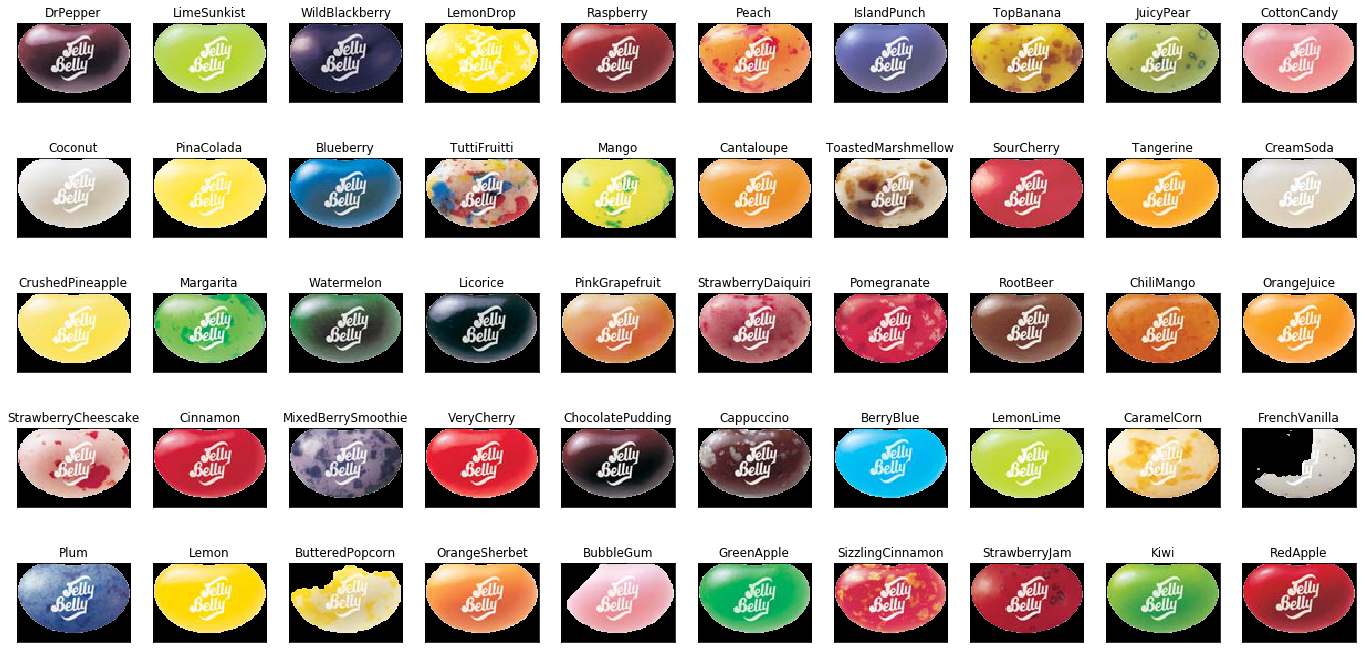

In [14]:
# Define the number of cols and rows of subplot as needed.
# There are 50 flavours in my dataset, so here I'm using a
# [5 x 10] matrix to display result
_ALLF_ROWS, _ALLF_COLS = 5, 10

# Generate segmented images without background pixels
bean_seg = []
for b_name, b in zip(beanflavours, bean_imgs):
    mask = np.zeros(b.shape[:2],np.uint8)
    rect = (1,1, b.shape[1] - 2, b.shape[0] - 2)
    cv.grabCut(b, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    # Add alpha channel
    nb = cv.cvtColor(b, cv.COLOR_BGR2BGRA) * mask2[:,:,np.newaxis]
    bean_seg.append(nb)


# Display result
fig, axs = plt.subplots(nrows=_ALLF_ROWS, ncols=_ALLF_COLS, figsize=(24, 12))
for i in range(_ALLF_ROWS):
    for j in range(_ALLF_COLS):
        fid = (_ALLF_COLS * i) + j
        axs[i, j].imshow(cv.cvtColor(bean_seg[fid], cv.COLOR_BGR2RGB))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(beanflavours[fid])

plt.draw()

Seems like some of the images are not well cropped. We can fine-tune the parameters to obtain ideal result, but I'll just modify target boundary here to get acceptable result.

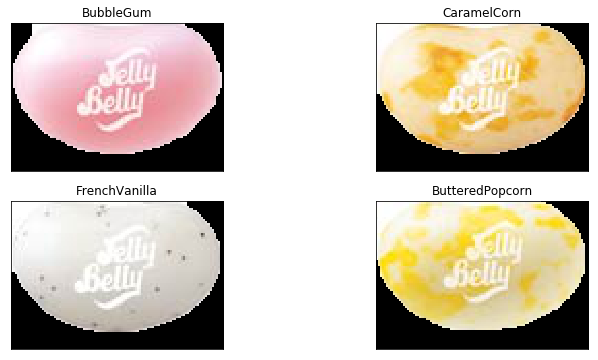

In [16]:
relaxed_flavour_list = ["BubbleGum", "CaramelCorn",
                        "FrenchVanilla", "ButteredPopcorn"]
tuned_rects = [
    (1, 0, 101, 65), (0, 0, 101, 65),
    (0, 0, 101, 65), (0, 0, 101, 63)
]
relaxed_flavour_idx = [beanflavours.index(f) for f in relaxed_flavour_list]

# Finally, output all segmented images.
for b_name, b_idx, bbox in zip(relaxed_flavour_list, relaxed_flavour_idx, tuned_rects):
    b = bean_imgs[b_idx]
    mask = np.zeros(b.shape[:2],np.uint8)
    rect = bbox
    cv.grabCut(b, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    nb = cv.cvtColor(b, cv.COLOR_BGR2BGRA) * mask2[:,:,np.newaxis]
    bean_seg[b_idx] = (nb)

# Display result
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
for i in range(2):
    for j in range(2):
        fid = relaxed_flavour_idx[(2 * i) + j]
        axs[i, j].imshow(cv.cvtColor(bean_seg[fid], cv.COLOR_BGR2RGB))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(beanflavours[fid])
plt.draw()

In [17]:
# Save the files
for bname, seg_img in zip(beanflavours, bean_seg):
    cv.imwrite(os.path.join(_BEANS_OUTPATH, bname + ".png"), seg_img)

In this section, we want to create some randomized pictures with jelly beans spreaded on it, and generate annotation data at the meantime. We can crop the images first to reduce size of boundary boxes, thus helps the model to locate the target more accurately.

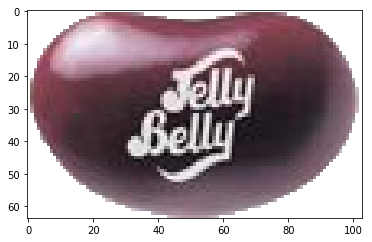

In [18]:
# Clip segmented images
clip_lower = 64
beans_sand = [b.copy()[:clip_lower,:,:] for b in bean_seg]

plt.imshow(cv.cvtColor(beans_sand[0], cv.COLOR_BGRA2RGBA))
plt.show()

We want to rotate the beans to make some randomness, so here we introduce a function that generates rotated image.

In [19]:
# There's some annoying issue for installing imutils on anaconda,
# so I directly copied the function right here.
# Reference:
# https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv.warpAffine(image, M, (nW, nH))

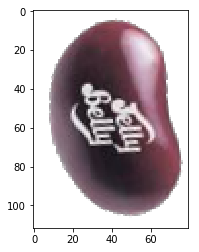

In [20]:
bean_rotated = rotate_bound(beans_sand[0], 80.0)
plt.imshow(cv.cvtColor(bean_rotated, cv.COLOR_BGRA2RGBA))
plt.show()

Here's the function for generating images of spreaded jelly beans. You can modify the global parameters to generate different kinds of output.

In [21]:
_CANVAS_WIDTH, _CANVAS_HEIGHT, _CANVAS_MARGIN = 2400, 1800, 30
_SCALE_MIN, _SCALE_MAX = 0.75, 1.25
_NUM_OUTPUT = 2000
_ROTATION_MAX = 360.0

_MESS_SIZE = 4000 # Number of beans used as messed background

def random_bean_spread(beans, names, n=250, mess=True):
    canvas = np.ones((_CANVAS_HEIGHT, _CANVAS_WIDTH, 3), dtype=np.uint8) * random.randint(200, 255)
    csv_data = []
    mess_sz = _MESS_SIZE if mess else 0
    
    for i in range(mess_sz + n):
        y_center = random.randint(0 + _CANVAS_MARGIN, _CANVAS_HEIGHT - _CANVAS_MARGIN - 1)
        x_center = random.randint(0 + _CANVAS_MARGIN, _CANVAS_WIDTH - _CANVAS_MARGIN - 1)
        angle = 360.0 * random.random()
        rand_id = random.randint(0, len(beans) - 1)
        rand_bean, rand_tag = beans[rand_id], names[rand_id]
        scale = random.random() * (_SCALE_MAX - _SCALE_MIN) + _SCALE_MIN
        scaled_h = int(rand_bean.shape[0] * scale)
        scaled_w = int(rand_bean.shape[1] * scale)
        patch = cv.resize(rand_bean, (scaled_w, scaled_h))
        patch = rotate_bound(patch, angle)
        
        patch_h, patch_w = patch.shape[0], patch.shape[1]
        # Decide which pixel should occur at the center
        patch_hh = patch_h // 2 + 1 if patch_h % 2 else patch_h // 2
        patch_hw = patch_w // 2 + 1 if patch_w % 2 else patch_w // 2
        # Length of lower-part and upper-part(center included)
        # patch_hh and patch_hw already indicate the upper-part
        patch_hhl = patch_h - patch_hh
        patch_hwl = patch_w - patch_hw
        # Locate bbox of patch on the image and patch, and crop if needed.
        cloc_xmin = max(x_center - patch_hwl, 0)
        cloc_xmax = min(x_center + patch_hw - 1, _CANVAS_WIDTH - 1)
        cloc_ymin = max(y_center - patch_hhl, 0)
        cloc_ymax = min(y_center + patch_hh - 1, _CANVAS_HEIGHT - 1)
        # Do required cropping
        offset_xmin = (patch_hwl - x_center) if cloc_xmin == 0 else 0
        offset_xmax = (_CANVAS_WIDTH - x_center - patch_hw) if cloc_xmax == _CANVAS_WIDTH - 1 else None
        offset_ymin = (patch_hhl - y_center) if cloc_ymin == 0 else 0
        offset_ymax = (_CANVAS_HEIGHT - y_center - patch_hh) if cloc_ymax == _CANVAS_HEIGHT - 1 else None

        # Patch to the canvas
        alpha_mask = patch[offset_ymin:offset_ymax, offset_xmin:offset_xmax, 3].astype(np.bool)
        canvas[cloc_ymin:cloc_ymax+1, cloc_xmin:cloc_xmax+1,:][alpha_mask] = \
            patch[offset_ymin:offset_ymax, offset_xmin:offset_xmax, :3][alpha_mask]
        if i >= mess_sz:
            csv_data.append([cloc_xmin, cloc_ymin, cloc_xmax, cloc_ymax, rand_tag])
    return canvas, csv_data

Now, let's generate a randomized image.

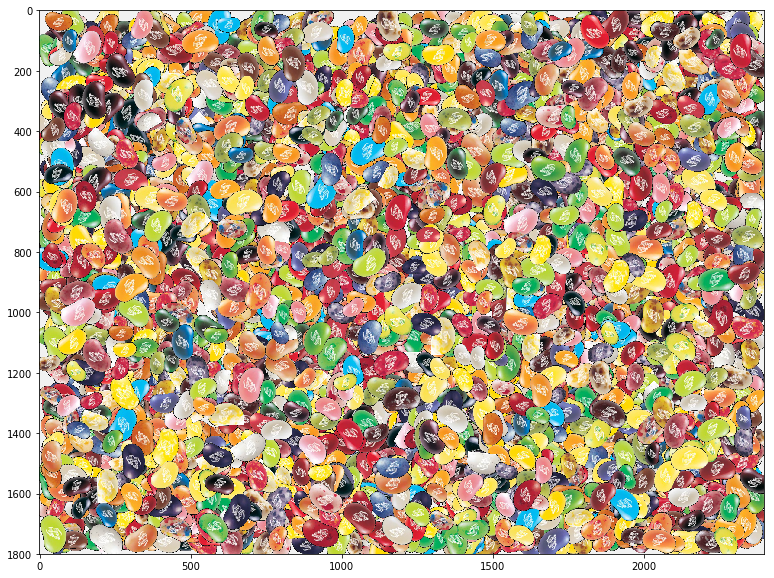

In [22]:
rand_img, rand_data = random_bean_spread(beans_sand, beanflavours)
plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(rand_img, cv.COLOR_BGR2RGB))
plt.show()

We messed the image with tons of beans in the background before patching annotated beans, so let's add bounding boxes of indentifying targets to make it clear.

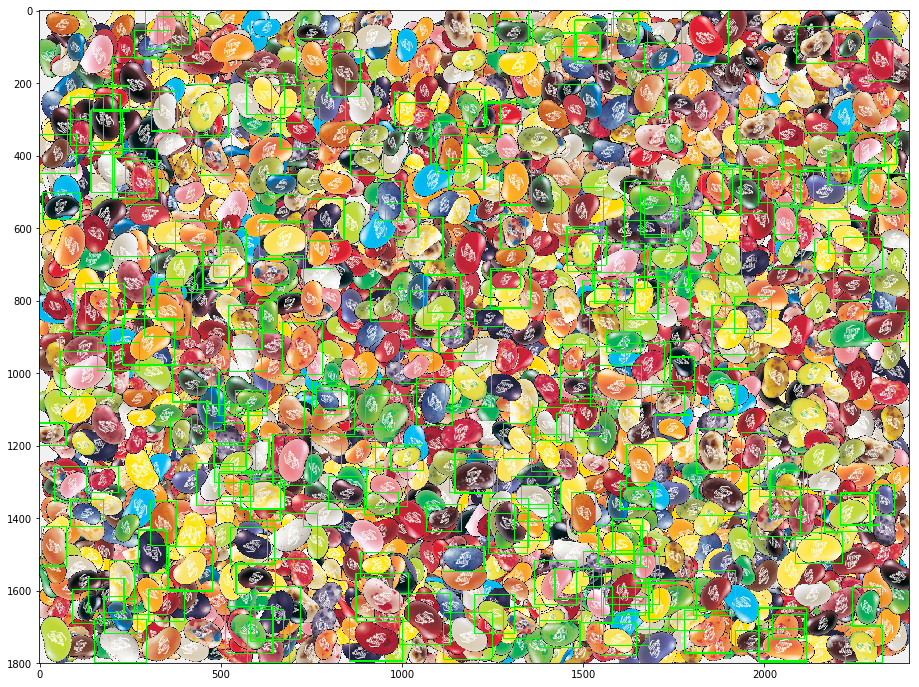

In [23]:
rand_img_annotated = rand_img.copy()
for xmin, ymin, xmax, ymax, _ in rand_data:
    cv.rectangle(rand_img_annotated, (xmin, ymin), (xmax, ymax),(0,255,0), 2)
    
plt.figure(figsize=(24,12))
plt.imshow(cv.cvtColor(rand_img_annotated, cv.COLOR_BGR2RGB))
plt.show()

Finally, output randomized images as training dataset. Note that around half of the images are having background filled with non-target jelly beans, while the others has background with single color.

In [26]:
_OUTPUT_PATH = "" # Place your output folder here
_N_RAND_IMG = 6   # Set number of images you want to generate
_FAIRCOIN = [True, False] # Used for background parameter 

# Generate files and annotation data
with open(os.path.join(_OUTPUT_PATH, "annotation.csv"), "w") as fd_w:
    for i in range(_N_RAND_IMG):
        filename = "sample_{:06d}.jpg".format(i)
        out_img_path = os.path.join(_OUTPUT_PATH, filename)
        rand_img, rand_data = random_bean_spread(beans_sand, beanflavours, mess=random.choice(_FAIRCOIN))
        print("Save file to {:s}...".format(out_img_path))
        cv.imwrite(out_img_path, rand_img)
        for row in rand_data:
            row_str = "{:s},{:d},{:d},{:d},{:d},{:s}\n".format(*([out_img_path] + row))
            fd_w.write(row_str)
print("Done!")

Save file to [OUTPUTPATH_1]...
Save file to [OUTPUTPATH_2]...
Save file to [OUTPUTPATH_3]...
Save file to [OUTPUTPATH_4]...
Save file to [OUTPUTPATH_5]...
Save file to [OUTPUTPATH_6]...
Done!


And don't forget to output mapping between class ID and flavour name.

In [27]:
with open(os.path.join(_OUTPUT_PATH, "classes.csv"), "w") as fd_w:
    for f_idx, f_name in enumerate(beanflavours):
        fd_w.write("{:s},{:d}\n".format(f_name, f_idx))
print("Done!")

Done!
